# GROUP PROJECT REPORT
Group 22 - Jeffery Hu, Ben Lu, Gurjas Singh Chawla, Feiran Hu

### Table of Contents
1. [Introduction](#i)
2. [Methods & Results](#mr)
   - [Loading Data](#loading-data)
   - [Wrangling, Tidying, and Cleaning Data](#wtcd)
   - [Exploratory Data Analysis Summary](#edas)
   - [Exploratory Data Analysis Visualization](#edav)
   - [Data Analysis](#da)
   - [Data Visualization](#dv)
4. [Discussion](#d)
5. [References](#r)

## Introduction <a name="i"/>
In data science, classification is the process where a set of observation is categorized into groups. K-nearest neighbour (KNN) is a form of classification where these observations in a data set are grouped based on their similarity with their neighbours. This report will demonstrate data wrangling, summarization, and visualization before performing KNN classification on a training dataset, then verifying our results via comparing with a testing dataset as well as a thorough data analysis along with a post analysis discussion.

In sports, left-handed players tend to perform better than their right-handed opponents - many hypothesize that this could be due to the rarity of left-handed players which leads to right-handed players' lack of experience playing against lefties, or that left-handed people are simply more coordinated and athletically inclined. An example of such study conducted on a broad range of sports can be found [here](https://web.p.ebscohost.com/ehost/pdfviewer/pdfviewer?vid=0&sid=c75a114d-74c5-4457-9772-81880b8b39ea%40redis), or adjacently relevant, [this study](https://web.archive.org/web/20090324225537/http://www.ucd.ie/geary/publications/2004/laterality.pdf) on how left-handed people earn more wage. As such, we believe it would be interesting to see if there would be any correlation between a tennis player’s handedness and their other attributes, or more formally: 

Is there a relationship between the handedness of a tennis player with their peak rank, current rank, height, age, and their backhand grip - i.e. can we derive the former by looking at their other attributes?

To answer our questions we will be using the Player Stats for Top 500 Players found [here](https://www.ultimatetennisstatistics.com/).

## Methods & Results <a name="mr"/>

In [71]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(gridExtra)
options(repr.plot.width = 10, repr.plot.height = 6)
options(repr.matrix.max.rows = 4)

### Loading Data <a name="loading-data" />
The first step to our data analysis is to load our data. As mentioned above, our data is found on the [Ultimate Tennis Statistics](https://www.ultimatetennisstatistics.com/) site and can be downloaded via [this Google Drive Link](https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS) as seen in the code cell below.

In [2]:
# tennis player data acquried from https://www.ultimatetennisstatistics.com/
url = "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "player_data.csv")

# player data with only the columns we want
player_data_raw <- read_csv("player_data.csv")
player_data_raw

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Wrangling, Tidying, and Cleaning Data <a name="wtcd" />
Wrangling, tidying, and cleaning data are all steps that are taken to ensure our data analysis can be performed smoothly and that the end result make sense. Below the raw player data is stripped of fields that we deem useless (such as the country a player is fromt as well as their various social media platforms) to our data analysis. Then the data with the remaining fields are formatted so that we can perform numeric summaries on them (i.e. turn the field age which contains the birthday and birthdays of a player, which is untidy, into a tidy variable with just the age of the player). Finally, we split the data into a training as well as a testing dataset, with the former being the observations used to create our model and the latter used to verify the validity of our model.

In [3]:
# set seed for reproducibility
set.seed(1234)

player_data <- player_data_raw |> select(Age, Plays, `Current Rank`, `Best Rank`, Backhand, Height)
colnames(player_data) <- c("age", "handedness", "curr_rank", "best_rank", "backhand_grip", "height") 

# player data formatted - char fields converted to numerical and categorical fields converted to factors
#                       - removes the necessary parts of each variable like the birthdays after each players' age,
#                         which is a cell that contains more than one value hence untidy
player_data_formatted <- player_data |>
    mutate(age = as.numeric(sapply(strsplit(age," "), getElement, 1)), 
           curr_rank = as.numeric(sapply(strsplit(curr_rank," "), getElement, 1)), 
           best_rank = as.numeric(sapply(strsplit(best_rank," "), getElement, 1)),
           height = as.numeric(sapply(strsplit(height," "), getElement, 1)),
           backhand_grip = as_factor(backhand_grip),
           handedness = as_factor(handedness)
          )

# splitting data into training and testing sets
players_split <- initial_split(player_data_formatted, prop = 3/4, strata = handedness)
players_train <- training(players_split)
players_test <- testing(players_split)

players_train

age,handedness,curr_rank,best_rank,backhand_grip,height
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
18,Left-handed,326,316,Two-handed,NA
23,Left-handed,431,319,Two-handed,NA
⋮,⋮,⋮,⋮,⋮,⋮
20,Right-handed,382,380,Two-handed,NA
26,Right-handed,5,4,One-handed,185


### Exploratory Data Analysis Summary <a name="edas"/>
This step of the process involes performing a preliminary and exploratory analysis on the data that will allow us to perform the actual analysis further down the line.

Some crucial point we have to address before performing classification that can be answered with this summary includes:

**Q:** Do all of our observations have non-null handedness? **A:** No, since we cannot verify our accuracy if the actual handedness of a player is not known hence we will discard the 35 observations with no handedness variables

**Q:** Which of the currently selected predictors should be removed from the classification process due to their being missing data? **A:** It seems that the majority of players are missing their height data so it wouldn't make sense to still include that variable, however, the variables with only a few missing or missing a relatively small portion compared to the total amount of players (such as the age, current rank, best rank, and backhand grip) can be kept.

**Q** Is there imbalance in the data? **A:** Yes, there is a clear disproportional distribution of right and left handed players, which reflects real-life where only roughly 10% of people are left-handed [(source)](https://medlineplus.gov/genetics/understanding/traits/handedness/).


In [4]:
# this summarization table allows us to see the distribution of handedness among players
handedness_distribution <- players_train |>
    filter(!is.na(handedness)) |>
    group_by(handedness) |>
    summarize(count = n())

# this summarization table allows us to see how many variables we are missing for each of the predictors 
# as well as the handedness of the players, this gives us an idea of which variable we should put 
# more emphasis on (rank & age) and which to potentially discard (height)
missing_variables <- players_train |>
    summarize(across(everything(), ~ sum(is.na(.))))

handedness_distribution
missing_variables

handedness,count
<fct>,<int>
Right-handed,293
Left-handed,47


age,handedness,curr_rank,best_rank,backhand_grip,height
<int>,<int>,<int>,<int>,<int>,<int>
1,34,4,1,65,296


### Exploratory Data Analysis Visualization <a name="edav"/>
To help us better understand our exploratory data analysis, we have created several figures to visualize the summary conducted above:

**Figure 1:** Distribution of the handedness of players - this allows us to once again see what the proportion of right-handed versus left-handed players is and informs us that the data is unbalanced (in favour of right-handed players). Due to this, we may need to oversample the observations involving left-handed players in order to get a better model.

**Figure 2:** Distribution of the backhand of players with respect to their handedness - this allows us to see if there are any relation between how a player holds their backhand with their handedness. This does not appear to be the case as both right-handed and left-handed players seem to prefer to hold their backhands with both of their hands.

**Figure 3:** Age vs Current rank with respect to handedness - this three-way relationship allows us to gain insight about if age affects ranking the same way in players that are right-handed vs players that are left-handed. From the figure shown, it does not appear there is a clear difference as despite the left-handed players having less observations (as mentioned above), the shape of the scatterplot is roughly the same.

`summarise()` has grouped output by 'handedness'. You can override using the
`.groups` argument.


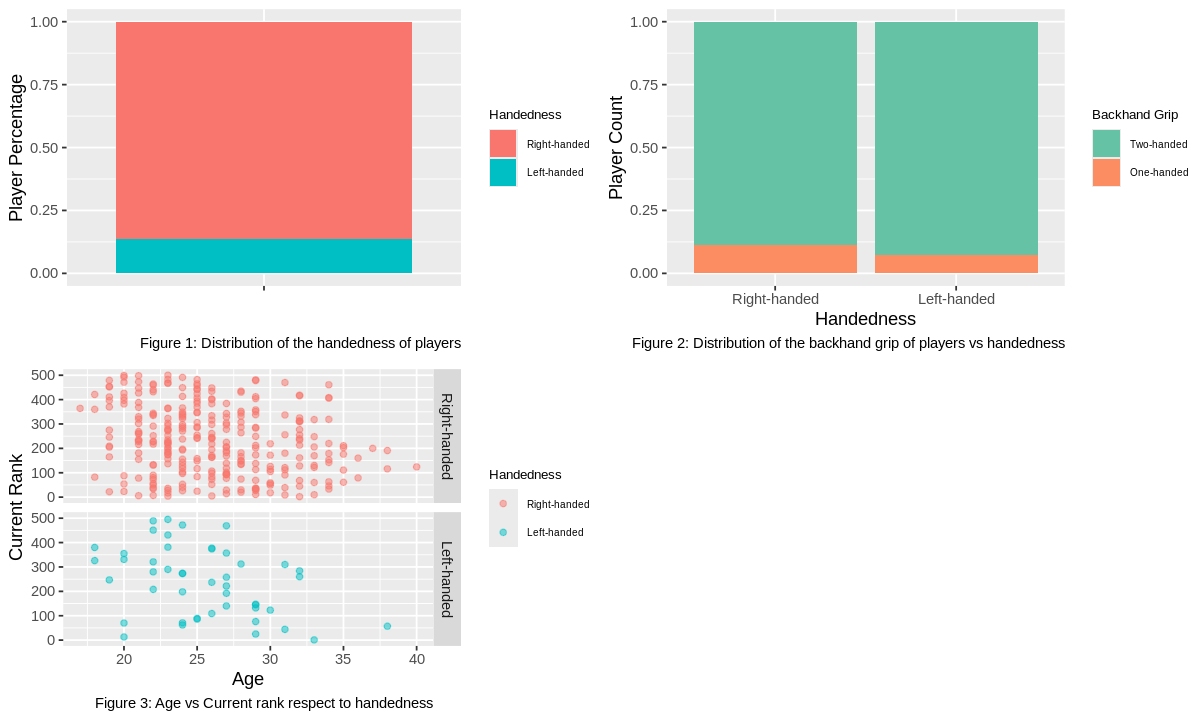

In [78]:
# visualizes the distribution of the handedness of players
plot1 <- ggplot(handedness_distribution, aes(x = "", y = count, fill = handedness)) +
    geom_bar(stat = 'identity', position = 'fill') +
    labs(x="", y = "Player Percentage", fill = "Handedness", caption="Figure 1: Distribution of the handedness of players") +
    theme(
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 6)
    )

# visualizes the distribution of the backhand grip of players vs what their handedness is
handedness_backhand_distribution <- players_train |>
    filter(!is.na(handedness), !is.na(backhand_grip)) |>
    group_by(handedness, backhand_grip) |>
    summarize(count = n())

plot2 <- ggplot(handedness_backhand_distribution, aes(x = handedness, y = count, fill = backhand_grip)) + 
    geom_bar(stat = 'identity', position = 'fill') +
    labs(x="Handedness", y = "Player Count", fill = "Backhand Grip", caption="Figure 2: Distribution of the backhand grip of players vs handedness") +
    scale_fill_brewer(palette = 'Set2') +
    theme(
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 6)
    )

# visualizes the distribution of age v.s. current rank of a player in respect to handedness
players_age_rank_handedness <- players_train |>
    filter(!is.na(handedness), !is.na(curr_rank), !is.na(age)) |>
    select(handedness, curr_rank, age)

plot3 <- ggplot(players_age_rank_handedness, aes(x = age, y = curr_rank, color = handedness)) +
    geom_point(alpha = 0.5) +
    labs(x="Age", y = "Current Rank", color = "Handedness", caption="Figure 3: Age vs Current rank respect to handedness") +
    facet_grid(rows = vars(handedness)) +
    theme(
        legend.title = element_text(size = 8), 
        legend.text = element_text(size = 6)
    )

grid.arrange(plot1, plot2, plot3, ncol = 2)

### Data Analysis <a name="da"/>

### Data Visualization <a name="dv"/>

## Discussion <a name="d"/>

## References <a name="r"/>